In [2]:
import numpy as np
import os
import torch


model_ensemble = []
model_path = os.path.join('models', 'gru-opt-cv10-sym')
for i in range(10):
    model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
    model.eval()
    model_ensemble.append(model)

In [3]:
archetype_sequences = {'liquid': 'BAABAABAABAABABBAAAB',
                     'membrane': 'ABAAABBAAAABBABBBAAA',
                     'spherical micelle': 'BBBBBBBBAAAAAAAAAAAA',
                     'string': 'ABBABABAAAAABABBABAA',
                     'vesicle': 'BABBBAABAAAABAABAABA',
                     'wormlike micelle': 'BBAAABBBAAAABBBAAAAA',
                     }
archetype_targets = {'liquid': np.array([20.471924,  2.369606]),
                     'membrane': np.array([1.214188, 9.048346]),
                     'spherical micelle': np.array([ 2.774236, -4.223681]),
                     'string': np.array([-4.319901,  7.762145]),
                     'vesicle': np.array([ 6.136077, 10.73103 ]),
                     'wormlike micelle': np.array([-4.627726,  0.183026]),
                     }
archetype_predictions = {'liquid': np.array([18.177, 2.932]),
                     'membrane': np.array([1.132, 8.499]),
                     'spherical micelle': np.array([2.901, -4.351]),
                     'string': np.array([-4.079, 6.662]),
                     'vesicle': np.array([6.498, 8.414]),
                     'wormlike micelle': np.array([-3.771, 0.172]),
                     }
archetype_plaintext = {'spherical micelle': 'spherical micelles',
                       'membrane': 'sheet-like membranes',
                       'wormlike micelle': 'worm-like micelles',
                       'liquid': 'amorphous liquid droplets',
                       'string': 'string-like aggregates',
                       # 'string': 'tangled intertwined polymer chain knots'
                       }
# morph = 'spherical micelle'
# morph = 'string'
# morph = 'liquid'
# morph = 'wormlike micelle'
morph = 'membrane'
# target = archetype_targets[morph]
target = archetype_predictions[morph]
target_description = archetype_plaintext[morph]
print(morph, ';', target_description, ';', target)

membrane ; sheet-like membranes ; [1.132 8.499]


In [3]:
import anthropic

with open('credentials-anthropic.txt', 'r') as fid:
    api_key = fid.read().strip() 

client = anthropic.Anthropic(api_key=api_key)

In [4]:
initial_prompt = f"I am performing MD simulations of sequence defined macromolecules with Kremer-Grest type potentials. There are attractive A-type beads and purely repulsive B-type beads connected by FENE springs. The polymer chains are 20-mers with a fixed composition of 12 A-type monomers. Please propose five 20-mers (in the format ABBA...) that are likely to form {target_description} so I can evaluate them with MD. Remember they must be 20-mers and should have 12 A-type beads."# I know that {archetype_sequences[morph]} gives a good result."

# batch_prompt = f""""Here are the sequences and their distance to the desired morphology:
# <result>
# Note that the target distance is less than 2. Please propose a new batch of 20-mers that are likely to form {target_description} so I can evaluate them with MD. Remember they must be 20-mers and should have 12 A-type beads. Please present the sequences as a code block.
# """

batch_prompt = f""""Here are the sequences and their distance to the desired morphology:
<result>
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-mers that are likely to form {target_description} so I can evaluate them with MD. Remember they must be 20-mers and should have 12 A-type beads."""

In [5]:
llm_model = "claude-3-opus-20240229"
# llm_model = "claude-3-sonnet-20240229"

"Here are the sequences and their distance to the desired morphology:
AAABABAAABAAABABAAAB: 9.394
AAABAABAABAAAABAAABA: 13.403
AABAAABAAAABAAABAAAB: 14.147
AABAAAABAAABAAABAABA: 14.276
AABAABAAABABAABAAAAB: 16.328
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-mers that are likely to form string-like aggregates so I can evaluate them with MD. Remember they must be 20-mers and should have 12 A-type beads.
"Here are the sequences and their distance to the desired morphology:
AAAAABAAAAAABAAAAAAB: 11.407
AAAAABAAAAABAAAAAAAB: 11.760
AAABAAAAAAABAAAAABAA: 13.633
AAABAAAAAABAAAAAABAA: 14.577
AABAAAAAAABAAAAAAABA: 15.351
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-mers that are likely to form string-like aggregates so I can evaluate them with MD. Remember they must be 20-mers and should have 12 A-type beads.
"Here are the sequences and their distance to the desired morphology:
A

(0.0, 18.0)

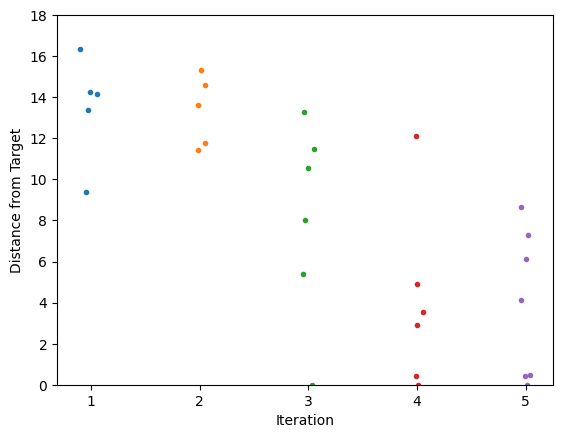

In [54]:
import json
import time
import message_utils, model_utils

max_tries = 5

# create initial message
messages = [{"role": "user", "content": [{"type": "text", "text": initial_prompt}]}]

params = {'llm_model': llm_model,
          'target': target.tolist(),
          'initial_prompt': initial_prompt,
          'batch_prompt': batch_prompt}

n_iter = 5
start_time = int(time.time())
for _ in range(n_iter):
    tries = 0
    response = None
    while tries < max_tries and response is None: 
        try:
            response = message_utils.send_message(messages, client, llm_model)
        except anthropic.InternalServerError:
            print('received InternalServerError, trying again...')
            tries += 1
    messages.append(message_utils.build_llm_message(response.content[0].text))
    result = message_utils.extract_AB_substrings(response.content[0].text)
    these_sequences = list(set(message_utils.postproc_sequences(result)))
    next_message = message_utils.build_user_message(batch_prompt, model_utils.evaluate_sequences(these_sequences, target, model_ensemble))
    messages.append(next_message)
    print(next_message['content'][0]['text'])

    buffer = {'params': params, 'messages': messages}
    with open(f'logs/claude-test-{start_time}.json', 'w') as fid:
        json.dump(buffer, fid)
        
fig, ax = message_utils.plot_results_from_messages(messages)
ax.set_ylim(0, 18)        

# without scientific knowledge

In [156]:
initial_prompt = f"I am performing MD simulations of sequence defined macromolecules with Kremer-Grest type potentials. There are attractive A-type beads and purely repulsive B-type beads connected by FENE springs. The MD simulation acts as an oracle, taking in a sequence of 20 tokens and returns the distance from the desired result. The input sequences are comprised of permutations of 12 A tokens and 8 B tokens. Please propose five of these 20-character sequences (in the format ABBA...) so I can evaluate them with the simulation. Remember they must be 20 characters long and should have 12 A characters. I know that {archetype_sequences[morph]} gives a good result."

initial_prompt = f"I am conducting molecular dynamics simulations involving sequences of 20 characters, comprising A and B characters. These sequences are governed by specific rules: 12 A characters are fixed, and the remaining 8 characters are B characters. Please propose five such 20-character sequences (in the format ABBA...) that are likely to exhibit {target_description} in my MD simulations. I will evaluate them based on certain criteria. Ensure the sequences adhere to the mentioned rules, and keep in mind the context of molecular dynamics simulations. I know that {archetype_sequences[morph]} gives a good result."

initial_prompt = f"I am engaged in a sequential learning experiment involving molecular dynamics simulations. The task is as follows: the language model will propose sequences of 20 characters, consisting of A and B characters, and I will evaluate them using MD simulations. The sequences are governed by specific rules where 12 A characters are fixed, and the remaining 8 characters are B characters. Please request the language model to generate five 20-character sequences (in the format ABBA...) that are likely to exhibit {target_description} in my MD simulations. I will assess them based on predefined criteria. Ensure that the proposed sequences adhere to the mentioned rules, and consider the context of sequential learning throughout the prompt. Hint: I know that {archetype_sequences[morph]} gives a good result."

batch_prompt = """"Here are the sequences and their distance to the desired result:
<result>
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the MD simulation. Remember they must be 20 characters long and should have 12 A characters."""

In [118]:
initial_prompt = f"I have an oracle that takes in a sequence of 20 characters and produces a distance from the desired result. The input sequences are comprised of permutations of 12 A characters and 8 B characters. Please propose five of these 20-character sequences (in the format ABBA...) so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters."

initial_prompt += f" Hint: I know that {archetype_sequences[morph]} gives a good result."

# initial_prompt = f"I am utilizing a language learning model (LLM) for a sequential learning task. The task involves an oracle that assesses the distance from the desired result based on a sequence of 20 characters. The input sequences consist of permutations of 12 'A' characters and 8 'B' characters. Could you kindly suggest five 20-character sequences (in the format ABBA...) for evaluation with the oracle? It's essential that these sequences are precisely 20 characters in length and contain exactly 12 'A' characters. Your assistance in generating diverse sequences would be greatly appreciated. Hint: I know that {archetype_sequences[morph]} gives a good result."

batch_prompt = """"Here are the sequences and their distance to the desired result:
<result>
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters."""

In [119]:
llm_model = "claude-3-opus-20240229"
# llm_model = "claude-3-sonnet-20240229"

In [26]:
import json
import time
import message_utils, model_utils

max_tries = 5

# create initial message
messages = [{"role": "user", "content": [{"type": "text", "text": initial_prompt}]}]

params = {'llm_model': llm_model,
          'target': target.tolist(),
          'initial_prompt': initial_prompt,
          'batch_prompt': batch_prompt}

n_iter = 10
start_time = int(time.time())
for _ in range(n_iter):
    tries = 0
    response = None
    while tries < max_tries and response is None: 
        try:
            response = message_utils.send_message(messages, client, llm_model)
        except anthropic.InternalServerError:
            print('received InternalServerError, trying again...')
            tries += 1
    messages.append(message_utils.build_llm_message(response.content[0].text))
    result = message_utils.extract_AB_substrings(response.content[0].text)
    these_sequences = list(set(message_utils.postproc_sequences(result)))
    next_message = message_utils.build_user_message(batch_prompt, model_utils.evaluate_sequences(these_sequences, target, model_ensemble))
    messages.append(next_message)
    print(next_message['content'][0]['text'])

    buffer = {'params': params, 'messages': messages}
    with open(f'logs/claude-test-{start_time}.json', 'w') as fid:
        json.dump(buffer, fid)

"Here are the sequences and their distance to the desired result:
ABBABABAAAAABABBABAA: 0.001
AAABBABAAAAABABBABAA: 1.373
AABABABAAAAABABBABAB: 1.524
ABBAABAAAAAABABBABAA: 1.610
BABABAAAAAABABBABABA: 5.576
ABABAABAAAABABBABABA: 16.597
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters.
"Here are the sequences and their distance to the desired result:
ABBABABAAAAABABBABAA: 0.001
ABBABABAAAABABBABAAA: 0.433
ABBABABAAAAABABBAABA: 4.107
ABBABABAAAAABABBABAB: 5.593
ABBABABAAAABABBAAAAB: 8.665
ABBABABAAAABABBABABA: 12.113
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters

In [173]:
logfile = meets_criteria[0]
with open(logfile, 'r') as fid:
    buffer = json.load(fid)
messages = buffer['messages']

In [177]:
import glob


def criteria(buffer):
    if "five" not in buffer['params']['initial_prompt']:
        return False
    if "Hint" not in buffer['params']['batch_prompt'] and "Hint" not in buffer['params']['initial_prompt']:
        return False
    if not np.allclose(buffer['params']['target'], archetype_predictions["membrane"]):
        return False
    if buffer['params']['llm_model'] != "claude-3-opus-20240229":
        return False
    return True

meets_criteria = []

logfiles = sorted(glob.glob('logs/claude-test-*.json'))
for log in logfiles:
    with open(log, 'r') as fid:
        buffer = json.load(fid)
    print(buffer['params']['target'])
    if criteria(buffer):
        meets_criteria.append(log)

print(meets_criteria)

[-4.319901, 7.762145]
[-4.319901, 7.762145]
[20.471924, 2.369606]
[20.471924, 2.369606]
[-4.627726, 0.183026]
[-4.627726, 0.183026]
[1.214188, 9.048346]
[1.214188, 9.048346]
[1.132, 8.499]
[1.132, 8.499]
[-4.079, 6.662]
[-4.079, 6.662]
[-3.771, 0.172]
[-3.771, 0.172]
[18.177, 2.932]
[18.177, 2.932]
[2.901, -4.351]
[2.901, -4.351]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[-3.771, 0.172]
[2.901, -4.351]
[2.901, -4.351]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.662]
[-4.079, 6.6

(0.1, 18.0)

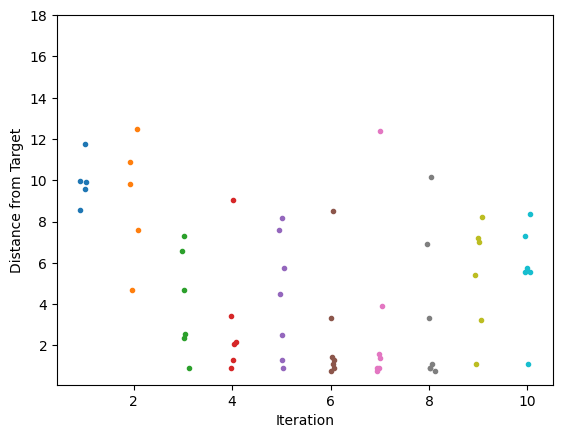

In [178]:
from message_utils import plot_results_from_messages
fig, ax = plot_results_from_messages(messages)
ax.set_ylim(0.10, 18)

In [21]:
# ask about the oracle
messages.pop()
messages.append({"role": "user", "content": [{"type": "text", "text": "The oracle is a computer simulation. Please conjecture about the nature of the simulation."}]})
response = message_utils.send_message(messages, client, llm_model)

In [22]:
print(response.content[0])

ContentBlock(text="Based on the patterns we've observed in the distances returned by the oracle, I suspect the simulation might be related to the distribution or clustering of similar elements within a sequence. Here are a few conjectures about the nature of the simulation:\n\n1. Molecular or Particle Interactions: The simulation could be modeling the behavior of molecules or particles in a system. The A and B characters might represent different types of molecules or particles, and the oracle is measuring the stability or energy of the system based on their arrangement. Longer stretches of similar characters (like consecutive A's) might lead to more stable or lower energy configurations.\n\n2. Pattern Recognition or Matching: The simulation might be comparing the input sequence to a predefined target pattern. The oracle's distance could be a measure of how closely the input sequence matches the desired pattern. In this case, the target pattern likely has a long stretch of A characters

# without history

In [44]:
import json
import time
import message_utils, model_utils

n_batch = "three"

initial_prompt = f"I have an oracle that takes in a sequence of 20 characters and produces a distance from the desired result. The input sequences are comprised of permutations of 12 A characters and 8 B characters. Please propose {n_batch} of these 20-character sequences (in the format ABBA...) so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters."

initial_prompt += f" I know that {archetype_sequences[morph]} gives a good result."

batch_prompt = f"""Here are the sequences you have tried so far, sorted by ascending distance to the desired result:
<result>
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of {n_batch} 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters."""

def extract_pairs(seq_and_dist):
    raw_pairs = seq_and_dist.split('\n')
    pairs = {}
    for p in raw_pairs:
        seq, dist = p.split(':')
        pairs[seq] = float(dist)
    return pairs

max_tries = 5

# create initial message
messages = [{"role": "user", "content": [{"type": "text", "text": initial_prompt}]}]

message_history = []
message_history.append(messages[0])

history = {}

params = {'llm_model': llm_model,
          'target': target.tolist(),
          'initial_prompt': initial_prompt,
          'batch_prompt': batch_prompt}

n_iter = 5
start_time = int(time.time())
for iter in range(n_iter):
    print(f'Iter: {iter:d}')
    print(messages[0]['content'][0]['text'])
    
    tries = 0
    response = None
    while tries < max_tries and response is None: 
        try:
            response = message_utils.send_message(messages, client, llm_model)
        except anthropic.InternalServerError:
            print('received InternalServerError, trying again...')
            tries += 1
    result = message_utils.extract_AB_substrings(response.content[0].text)
    
    these_sequences = list(set(message_utils.postproc_sequences(result)))
    seq_and_dist = model_utils.evaluate_sequences(these_sequences, target, model_ensemble)
    # print(seq_and_dist)
    
    pairs = extract_pairs(seq_and_dist)
    history.update(pairs)
    # print(history, pairs)
    
    seq_text = []
    for o in np.argsort(list(history.values())):
        key = list(history.keys())[o]
        seq_text.append(f'{key}: {history[key]:.3f}')
    next_message = message_utils.build_user_message(initial_prompt + '\n' + batch_prompt, '\n'.join(seq_text))
    messages = [next_message]
    message_history.append(next_message)
    # print(next_message['content'][0]['text'])

    buffer = {'params': params, 'messages': message_history}
    with open(f'logs/claude-test-{start_time}.json', 'w') as fid:
        json.dump(buffer, fid)

Iter: 0
I have an oracle that takes in a sequence of 20 characters and produces a distance from the desired result. The input sequences are comprised of permutations of 12 A characters and 8 B characters. Please propose three of these 20-character sequences (in the format ABBA...) so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters. I know that ABAAABBAAAABBABBBAAA gives a good result.
Iter: 1
I have an oracle that takes in a sequence of 20 characters and produces a distance from the desired result. The input sequences are comprised of permutations of 12 A characters and 8 B characters. Please propose three of these 20-character sequences (in the format ABBA...) so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters. I know that ABAAABBAAAABBABBBAAA gives a good result.
Here are the sequences you have tried so far, sorted by ascending distance to the desired result:
AB

(0.1, 18.0)

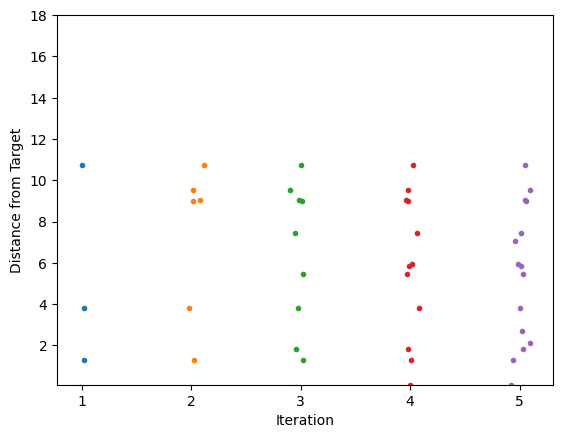

In [46]:
import matplotlib.pyplot as plt


def extract_seq_from_user_message(message):
    return message['content'][0]['text'].split('\n', 2)[2].split('Note', 1)[0]


def extract_results_from_messages(messages):
    user_messages = [it for it in messages if it['role'] == 'user']
    seq_lines = [extract_seq_from_user_message(it) for it in user_messages[1:]]
    iteration_scores = []
    for sl in seq_lines:
        scores = [float(it.split(':')[1]) for it in sl.split('\n')[:-1]]
        iteration_scores.append(scores)
    return iteration_scores


def plot_results_from_messages(messages):
    iteration_scores = extract_results_from_messages(messages)
    fig, ax = plt.subplots()
    top_range = 0
    for i, it in enumerate(extract_results_from_messages(messages)):
        ax.plot(np.ones(len(it))*(i+1)+np.random.randn(len(it))*0.05, it, '.')
        top_range = max(top_range, max(it))
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Distance from Target')
    ax.set_ylim(0, top_range*1.05)
    return fig, ax

# from message_utils import plot_results_from_messages
fig, ax = plot_results_from_messages(message_history)
ax.set_ylim(0.10, 18)

In [116]:
fake_payload

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'I have an oracle that takes in a sequence of 20 characters and produces a distance from the desired result. The input sequences are comprised of permutations of 12 A characters and 8 B characters. Please propose five of these 20-character sequences (in the format ABBA...) so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters. Hint: I know that ABBABABAAAAABABBABAA gives a good result.'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Here are five 20-character sequences that consist of 12 A characters and 8 B characters, based on the hint that ABBABABAAAAABABBABAA gives a good result:\n\n1. AABABABAAAAABABBABAB\n2. ABABAABAAAABABBABABA\n3. BABABAAAAAABABBABABA\n4. ABBAABAAAAAABABBABAA\n5. AAABBABAAAAABABBABAA'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': '"Here are the sequences and their distance to the desired result:\nABBA

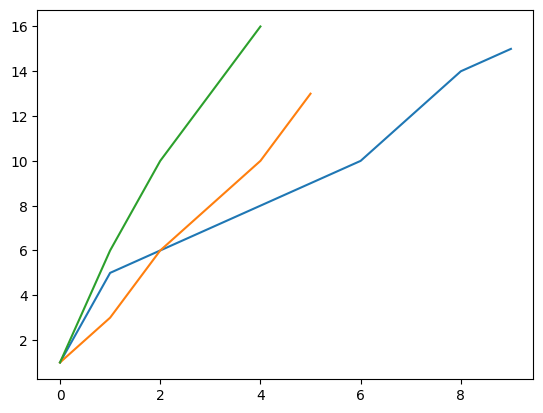

In [181]:
rollouts = []
for logfile in meets_criteria:
    with open(logfile, 'r') as fid:
        buffer = json.load(fid)
    messages = buffer['messages']
    rollouts.append(messages)

results = []
for fake_payload in rollouts:    
    iteration_scores = message_utils.extract_results_from_messages(fake_payload)
    scs = sorted_cumulative_scores(iteration_scores)
    kbd = k_below_d(scs, 0.67*2)
    results.append(kbd)

for r in results:
    plt.plot(r)
# plt.plot(np.array(results).mean(axis=0), '--')

# random sampling

In [4]:
# generate all sequences by composition
n = 20
all_seq_by_frac = {k: set() for k in range(n+1)}
limit = 2**n
for i in range(limit):
    sequence = bin(i)[2:].zfill(n)
    mirror_sequence = sequence[::-1]
    if sequence <= mirror_sequence:
        all_seq_by_frac[sequence.count('1')].add(sequence)

# create a master list of all possible sequences
all_sequences = []
for k, v in all_seq_by_frac.items():
    all_sequences += v
print(f'generated {len(all_sequences)} sequences')

generated 524800 sequences


In [23]:
morph = "membrane"
target = archetype_predictions[morph]

batch_prompt = "Here\n<result>\nNote"

rollouts = []

In [24]:
import model_utils, message_utils

for _ in range(10):
    
    fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
    
    possible_sequences = all_seq_by_frac[8]
    print(f'choosing from {len(possible_sequences)} sequences')
    
    n_batch = 5
    
    for _ in range(25):
        these_bitstr = np.random.choice(list(possible_sequences), n_batch, replace=False)
        these_sequences = [it.replace('0', 'A').replace('1', 'B') for it in these_bitstr]
        
        out = model_utils.evaluate_sequences(these_sequences, target, model_ensemble)
        fake_payload.append(message_utils.build_user_message(batch_prompt, out))
    
    
    rollouts.append(fake_payload)
    
# fig, ax = plot_results_from_messages(fake_payload)
# ax.set_ylim(0, 18)

choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences
choosing from 63090 sequences


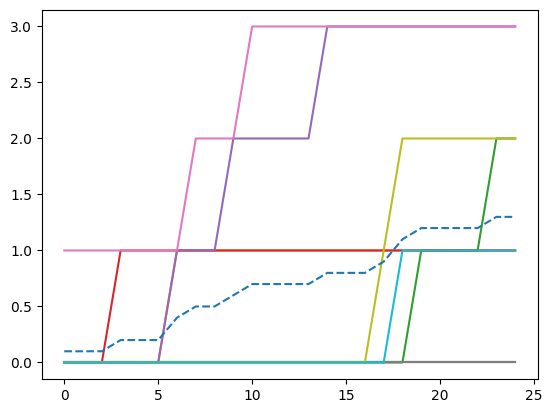

In [25]:
import matplotlib.pyplot as plt

def sorted_cumulative_scores(iteration_scores):
    out = [sorted(iteration_scores[0])]
    for it in iteration_scores[1:]:
        out.append(sorted(it+out[-1]))
    return out

def k_below_d(scores, d):
    out = []
    for iter in scores:
        out.append(len([it for it in iter if it < d]))
    return out

results = []
for fake_payload in rollouts:    
    iteration_scores = message_utils.extract_results_from_messages(fake_payload)
    scs = sorted_cumulative_scores(iteration_scores)
    kbd = k_below_d(scs, 0.67*2)
    results.append(kbd)

for r in results:
    plt.plot(r)
plt.plot(np.array(results).mean(axis=0), '--')
# plt.xlim(0, 9)
# plt.ylim(0, 40)

# RF active learning

In [203]:
import numpy as np
from sklearn import ensemble, model_selection


class EnsembleRFModel(object):

    def __init__(self, n_models=3, constructor=ensemble.RandomForestRegressor, model_params={}):
        self.n_models = n_models
        self.model_params = model_params
        self.models = [constructor(**self.model_params) for _ in range(self.n_models)]

    def fit(self, x, y):
        cv = model_selection.KFold(n_splits=self.n_models, shuffle=True, random_state=0)
        for i, (fold_train_idx, fold_val_idx) in enumerate(cv.split(x)):
            _ = self.models[i].fit(x[fold_train_idx], y[fold_train_idx])
        return self

    def predict(self, x, return_std=False):
        all_y = np.vstack([it.predict(x).reshape(1, -1) for it in self.models])

        if return_std:
            return np.mean(all_y, axis=0), np.std(all_y, axis=0)
        else:
            return np.mean(all_y, axis=0)

In [226]:
from sklearn import ensemble

fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]

AB = {'A': 0, 'B': 1}
all_arrs = np.array([[int(x) for x in s] for s in possible_sequences])

# rf = ensemble.RandomForestRegressor(random_state=0)
rf = EnsembleRFModel(model_params={'random_state': 0, 'n_estimators': 32, 'max_depth': 8})

n_init = 100
init_bitstr = np.random.choice(list(possible_sequences), n_init, replace=False)
init_sequences = [it.replace('0', 'A').replace('1', 'B') for it in init_bitstr]

x_so_far = np.array([[int(AB[x]) for x in s] for s in init_sequences])

out = model_utils.evaluate_sequences(init_sequences, target, model_ensemble)
fake_payload.append(message_utils.build_user_message(batch_prompt, out))
y_so_far = np.array([float(it.split(':')[1]) for it in out.split('\n')])

_ = rf.fit(x_so_far, y_so_far)

100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


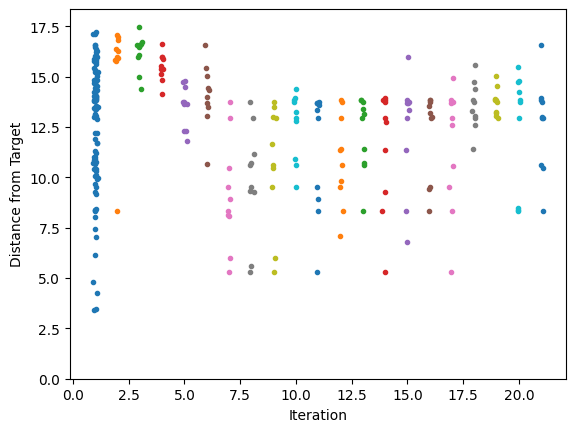

In [227]:
import tqdm

for _ in tqdm.tqdm(range(20)):
    
    mu, sigma = rf.predict(all_arrs, return_std=True)
    # o = np.hstack([np.argsort(mu - sigma)[:5], np.argsort(mu)[:5], np.argsort(-sigma)[:5]])
    o = np.hstack([np.argsort(mu)[:10]])
    next_bitstr = [list(possible_sequences)[it] for it in o]
    next_sequences = [it.replace('0', 'A').replace('1', 'B') for it in next_bitstr]
    
    x_so_far = np.vstack([x_so_far, np.array([[int(AB[x]) for x in s] for s in next_sequences])])
    
    out = model_utils.evaluate_sequences(next_sequences, target, model_ensemble)
    fake_payload.append(message_utils.build_user_message(batch_prompt, out))
    y_so_far = np.hstack([y_so_far, np.array([float(it.split(':')[1]) for it in out.split('\n')])])
    
    _ = rf.fit(x_so_far, y_so_far)
    
fig, ax = plot_results_from_messages(fake_payload)    

# GP on tokens? like with dragonfly?

# GPT

In [23]:
import json
from openai import OpenAI

with open("credentials-openai.json", "r") as fid:
    credentials = json.load(fid)

client = OpenAI(api_key=credentials["api_key"])

In [24]:
# create initial message
messages = [{"role": "user", "content": initial_prompt}]

llm_model = "gpt-4-0125-preview"
# llm_model = "gpt-4-1106-preview"

def send_openai_message(messages, client, model):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
        temperature=0.,
    )
    return response


n_iter = 5
for _ in range(n_iter):
    response = send_openai_message(messages, client, llm_model)
    plaintext = response.choices[0].message.content
    llm_message = {'role': 'assistant', 'content': plaintext}
    messages.append(llm_message)
    result = message_utils.extract_AB_substrings(plaintext)
    these_sequences = message_utils.postproc_sequences(result)
    prediction = model_utils.evaluate_sequences(these_sequences, target, model_ensemble)
    next_message = {'role': 'user', 'content': batch_prompt.replace('<result>', prediction)}
    messages.append(next_message)
    print(next_message['content'])

params = {'llm_model': llm_model,
          'target': target.tolist(),
          'initial_prompt': initial_prompt,
          'batch_prompt': batch_prompt}
buffer = {'params': params, 'messages': messages}

with open(f'logs/openai-test-{time.time()}.json', 'w') as fid:
    json.dump(buffer, fid)

"Here are the sequences and their distance to the desired result:
AAABAAABABABABBABAAB: 6.520
AAAABBBBAAAAABABABAB: 11.117
ABABABABAAABAAABABAB: 12.175
AABBAABBAAABABABABAA: 12.200
BABAABABAAABAABAABAA: 13.083
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters.
"Here are the sequences and their distance to the desired result:
AAABAAABABABBABAABAB: 5.938
AAABAAABABABABBABAAB: 6.520
AAABAAABBABABABBABAA: 7.239
AAABAABABABABBABAABA: 11.096
AABAABAAABABABBABAAB: 11.694
AAABABAABABABBABAABA: 12.228
Note that only distances less than 1.0 represent good solutions. Please propose a new batch of five 20-character sequences that are closer to my target so I can evaluate them with the oracle. Remember they must be 20 characters long and should have 12 A characters.
"Here are the sequenc

(0.0, 18.0)

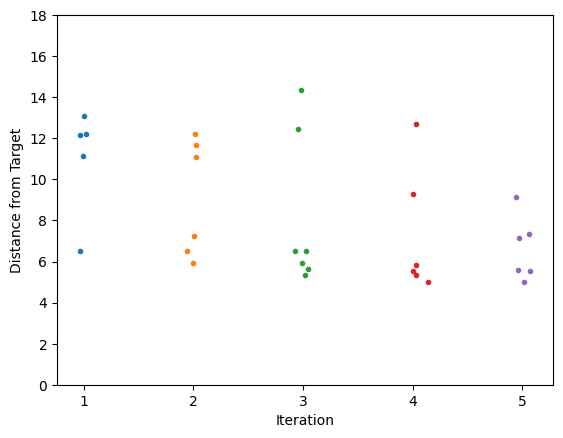

In [25]:
def make_claude_messages_from_openai(messages):
    payload = []
    for m in messages:
        # message['content'][0]['text']
        this = {'role': m['role'], 'content': [{'text': m['content']}]}
        payload.append(this)
    return payload

fig, ax = plot_results_from_messages(make_claude_messages_from_openai(messages))
ax.set_ylim(0, 18)

In [ ]:
# ask about the oracle
messages.pop()
messages.append({"role": "user", "content": [{"type": "text", "text": "The oracle is a computer simulation. Please conjecture about the nature of the simulation."}]})
response = message_utils.send_message(messages, client, llm_model)

# human expert sampling